In [10]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import timeit
import os

DATA_DIR="/kaggle/input/fast-food-classification-dataset/Fast Food Classification V2/Train"
BATCH_SIZE = 128
IMG_SIZE = 64
CHANNELS = 3
INPUT_VECTOR_DIM = 100
FEATURE_MAP_DIM = 64
LR = 2e-4
BETA1 = 0.5
EPOCHS = 500
RANDOM_SEED = 42
CHECKPOINT = "/kaggle/working/checkpoints"

if not os.path.exists(CHECKPOINT):
    os.makedirs(CHECKPOINT)
    print(f"Created checkpoint directory: {CHECKPOINT}")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class Discriminator(nn.Module):
  def __init__(self, feature_map_dim, channels):
    super(Discriminator, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=channels, out_channels=feature_map_dim*2, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_2 = nn.Conv2d(in_channels=feature_map_dim*2, out_channels=feature_map_dim*4, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_3 = nn.Conv2d(in_channels=feature_map_dim*4, out_channels=feature_map_dim*8, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_4 = nn.Conv2d(in_channels=feature_map_dim*8, out_channels=feature_map_dim*16, kernel_size=4, stride=2, padding=1, bias=False )
    self.conv_5 = nn.Conv2d(in_channels=feature_map_dim*16, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False )

    self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

    self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
    self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
    self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)

    self.sigmoid = nn.Sigmoid()

  def forward(self, inp):
    x = self.conv_1(inp)
    x = self.leaky_relu(x)

    x = self.conv_2(x)
    x = self.batch_norm_1(x)
    x = self.leaky_relu(x)

    x = self.conv_3(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu(x)

    x = self.conv_4(x)
    x = self.batch_norm_3(x)
    x = self.leaky_relu(x)

    x = self.conv_5(x)
    out = self.sigmoid(x)

    return out

In [11]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)
x =  torch.randn(BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
dis_out = discriminator(x)
print(dis_out.size())

torch.Size([128, 1, 1, 1])


In [12]:
class Generator(nn.Module):
  def __init__(self, input_vector, feature_map_dim, channels):
    super(Generator, self).__init__()
    self.convt_1 = nn.ConvTranspose2d(in_channels=input_vector, out_channels=feature_map_dim*16, kernel_size=4, stride=1, padding=0, bias=False)
    self.convt_2 = nn.ConvTranspose2d(in_channels=feature_map_dim*16, out_channels=feature_map_dim*8, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_3 = nn.ConvTranspose2d(in_channels=feature_map_dim*8, out_channels=feature_map_dim*4, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_4 = nn.ConvTranspose2d(in_channels=feature_map_dim*4, out_channels=feature_map_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
    self.convt_5 = nn.ConvTranspose2d(in_channels=feature_map_dim*2, out_channels=channels, kernel_size=4, stride=2, padding=1, bias=False)

    self.relu = nn.ReLU(True)

    self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
    self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
    self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
    self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)

    self.tanh = nn.Tanh()

  def forward(self, inp):
    x = self.convt_1(inp)
    x = self.batch_norm_1(x)
    x = self.relu(x)

    x = self.convt_2(x)
    x = self.batch_norm_2(x)
    x = self.relu(x)

    x = self.convt_3(x)
    x = self.batch_norm_3(x)
    x = self.relu(x)

    x = self.convt_4(x)
    x = self.batch_norm_4(x)
    x = self.relu(x)

    x = self.convt_5(x)
    out = self.tanh(x)

    return out

In [13]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)
noise = torch.randn(BATCH_SIZE, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())

torch.Size([128, 3, 64, 64])


In [14]:
dataset = ImageFolder(DATA_DIR,
                      transform=transforms.Compose([
                          transforms.Resize(IMG_SIZE),
                          transforms.CenterCrop(IMG_SIZE),
                          transforms.ToTensor(),
                          transforms.Normalize(*((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
                      ]))
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

Generator params: 12658432
Discriminator params: 11036160


 11%|█         | 13/118 [00:15<01:58,  1.13s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 118/118 [02:15<00:00,  1.15s/it]


Discriminator Loss EPOCH 1: 6866.3880
Generator Loss EPOCH 1: 8.7783


  0%|          | 2/500 [03:14<12:33:14, 90.75s/it] 

Discriminator Loss EPOCH 2: 6837.8073
Generator Loss EPOCH 2: 2.6366


  1%|          | 3/500 [04:14<10:32:20, 76.34s/it]

Discriminator Loss EPOCH 3: 7136.2606
Generator Loss EPOCH 3: 2.8171


  1%|          | 4/500 [05:14<9:37:22, 69.84s/it] 

Discriminator Loss EPOCH 4: 6287.0859
Generator Loss EPOCH 4: 3.2726


  1%|          | 5/500 [06:13<9:05:52, 66.17s/it]

Discriminator Loss EPOCH 5: 6137.2620
Generator Loss EPOCH 5: 3.3146


  1%|          | 6/500 [07:14<8:49:22, 64.30s/it]

Discriminator Loss EPOCH 6: 5872.6197
Generator Loss EPOCH 6: 3.1325


  1%|▏         | 7/500 [08:14<8:35:55, 62.79s/it]

Discriminator Loss EPOCH 7: 6320.7726
Generator Loss EPOCH 7: 3.0761


  2%|▏         | 8/500 [09:13<8:26:34, 61.78s/it]

Discriminator Loss EPOCH 8: 6109.7085
Generator Loss EPOCH 8: 3.3295


  2%|▏         | 9/500 [10:13<8:20:27, 61.16s/it]

Discriminator Loss EPOCH 9: 5789.4791
Generator Loss EPOCH 9: 3.8353


  2%|▏         | 10/500 [11:12<8:14:05, 60.50s/it]

Discriminator Loss EPOCH 10: 5783.4678
Generator Loss EPOCH 10: 3.6528


  2%|▏         | 11/500 [12:12<8:10:46, 60.22s/it]

Discriminator Loss EPOCH 11: 5018.3513
Generator Loss EPOCH 11: 4.0483


  2%|▏         | 12/500 [13:11<8:07:55, 59.99s/it]

Discriminator Loss EPOCH 12: 4648.6586
Generator Loss EPOCH 12: 4.2377


  3%|▎         | 13/500 [14:10<8:05:33, 59.82s/it]

Discriminator Loss EPOCH 13: 4902.1017
Generator Loss EPOCH 13: 4.2482


  3%|▎         | 14/500 [15:10<8:03:41, 59.72s/it]

Discriminator Loss EPOCH 14: 4302.0299
Generator Loss EPOCH 14: 4.6338


  3%|▎         | 15/500 [16:09<8:01:17, 59.54s/it]

Discriminator Loss EPOCH 15: 3618.0492
Generator Loss EPOCH 15: 4.6460


  3%|▎         | 16/500 [17:09<8:00:49, 59.61s/it]

Discriminator Loss EPOCH 16: 4212.7834
Generator Loss EPOCH 16: 4.8113


  3%|▎         | 17/500 [18:09<8:00:20, 59.67s/it]

Discriminator Loss EPOCH 17: 4090.8556
Generator Loss EPOCH 17: 5.0221


  4%|▎         | 18/500 [19:10<8:02:52, 60.11s/it]

Discriminator Loss EPOCH 18: 3997.9266
Generator Loss EPOCH 18: 4.7358


  4%|▍         | 19/500 [20:12<8:06:55, 60.74s/it]

Discriminator Loss EPOCH 19: 4100.1018
Generator Loss EPOCH 19: 4.6949


  4%|▍         | 20/500 [21:15<8:10:50, 61.35s/it]

Discriminator Loss EPOCH 20: 3144.6542
Generator Loss EPOCH 20: 4.7781


100%|██████████| 118/118 [01:01<00:00,  1.92it/s]


Discriminator Loss EPOCH 21: 3598.9222
Generator Loss EPOCH 21: 4.5277


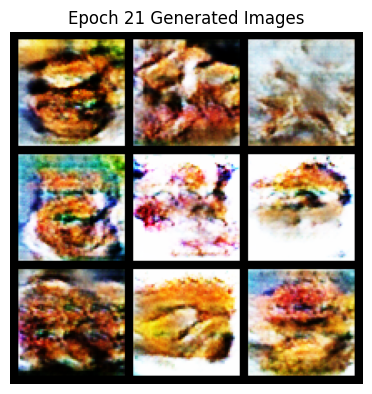

  4%|▍         | 22/500 [23:16<8:05:46, 60.97s/it]

Discriminator Loss EPOCH 22: 4087.9723
Generator Loss EPOCH 22: 4.8101


  5%|▍         | 23/500 [24:16<8:01:34, 60.57s/it]

Discriminator Loss EPOCH 23: 3827.8273
Generator Loss EPOCH 23: 4.8702


  5%|▍         | 24/500 [25:16<7:59:06, 60.39s/it]

Discriminator Loss EPOCH 24: 3550.8957
Generator Loss EPOCH 24: 5.1322


  5%|▌         | 25/500 [26:16<7:56:25, 60.18s/it]

Discriminator Loss EPOCH 25: 3200.3913
Generator Loss EPOCH 25: 4.9307


  5%|▌         | 26/500 [27:15<7:54:19, 60.04s/it]

Discriminator Loss EPOCH 26: 3879.8332
Generator Loss EPOCH 26: 4.9596


  5%|▌         | 27/500 [28:15<7:52:19, 59.91s/it]

Discriminator Loss EPOCH 27: 3081.5991
Generator Loss EPOCH 27: 4.8043


  6%|▌         | 28/500 [29:14<7:50:18, 59.79s/it]

Discriminator Loss EPOCH 28: 3006.5190
Generator Loss EPOCH 28: 4.9448


  6%|▌         | 29/500 [30:15<7:50:52, 59.98s/it]

Discriminator Loss EPOCH 29: 3175.6194
Generator Loss EPOCH 29: 5.2250


  6%|▌         | 30/500 [31:15<7:51:28, 60.19s/it]

Discriminator Loss EPOCH 30: 3074.5564
Generator Loss EPOCH 30: 5.3387


  6%|▌         | 31/500 [32:16<7:51:37, 60.34s/it]

Discriminator Loss EPOCH 31: 2846.3937
Generator Loss EPOCH 31: 5.2007


  6%|▋         | 32/500 [33:17<7:51:48, 60.49s/it]

Discriminator Loss EPOCH 32: 2672.8389
Generator Loss EPOCH 32: 5.4685


  7%|▋         | 33/500 [34:17<7:49:52, 60.37s/it]

Discriminator Loss EPOCH 33: 3435.7538
Generator Loss EPOCH 33: 5.2353


  7%|▋         | 34/500 [35:18<7:50:52, 60.63s/it]

Discriminator Loss EPOCH 34: 2147.5841
Generator Loss EPOCH 34: 5.0645


  7%|▋         | 35/500 [36:20<7:51:49, 60.88s/it]

Discriminator Loss EPOCH 35: 2486.8915
Generator Loss EPOCH 35: 5.5238


  7%|▋         | 36/500 [37:21<7:51:11, 60.93s/it]

Discriminator Loss EPOCH 36: 2955.6355
Generator Loss EPOCH 36: 5.2762


  7%|▋         | 37/500 [38:21<7:48:17, 60.69s/it]

Discriminator Loss EPOCH 37: 2293.6549
Generator Loss EPOCH 37: 5.4352


  8%|▊         | 38/500 [39:21<7:45:38, 60.47s/it]

Discriminator Loss EPOCH 38: 2799.2091
Generator Loss EPOCH 38: 5.6335


  8%|▊         | 39/500 [40:20<7:42:20, 60.18s/it]

Discriminator Loss EPOCH 39: 2802.1285
Generator Loss EPOCH 39: 4.9296


  8%|▊         | 40/500 [41:19<7:38:26, 59.80s/it]

Discriminator Loss EPOCH 40: 2276.3111
Generator Loss EPOCH 40: 5.1529


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 41: 3171.2453
Generator Loss EPOCH 41: 5.1344


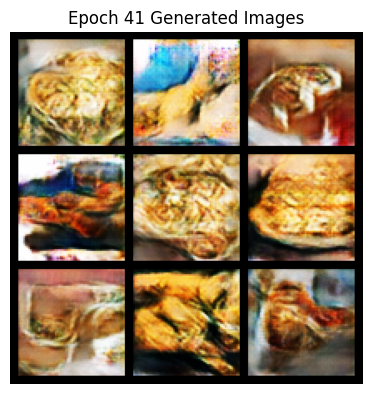

  8%|▊         | 42/500 [43:18<7:34:04, 59.49s/it]

Discriminator Loss EPOCH 42: 3121.0229
Generator Loss EPOCH 42: 5.0252


  9%|▊         | 43/500 [44:17<7:32:00, 59.34s/it]

Discriminator Loss EPOCH 43: 1400.0901
Generator Loss EPOCH 43: 5.1665


  9%|▉         | 44/500 [45:16<7:29:53, 59.20s/it]

Discriminator Loss EPOCH 44: 2843.7688
Generator Loss EPOCH 44: 5.3521


  9%|▉         | 45/500 [46:14<7:27:53, 59.06s/it]

Discriminator Loss EPOCH 45: 3650.0876
Generator Loss EPOCH 45: 5.1326


  9%|▉         | 46/500 [47:13<7:26:50, 59.05s/it]

Discriminator Loss EPOCH 46: 1705.3373
Generator Loss EPOCH 46: 4.8420


  9%|▉         | 47/500 [48:12<7:25:17, 58.98s/it]

Discriminator Loss EPOCH 47: 3056.2134
Generator Loss EPOCH 47: 5.1253


 10%|▉         | 48/500 [49:12<7:26:33, 59.28s/it]

Discriminator Loss EPOCH 48: 1788.4321
Generator Loss EPOCH 48: 5.1472


 10%|▉         | 49/500 [50:12<7:26:40, 59.42s/it]

Discriminator Loss EPOCH 49: 2288.7335
Generator Loss EPOCH 49: 5.0611


 10%|█         | 50/500 [51:11<7:24:41, 59.29s/it]

Discriminator Loss EPOCH 50: 1695.5785
Generator Loss EPOCH 50: 5.0164


 10%|█         | 51/500 [52:10<7:23:22, 59.25s/it]

Discriminator Loss EPOCH 51: 3715.9004
Generator Loss EPOCH 51: 4.8723


 10%|█         | 52/500 [53:09<7:21:21, 59.11s/it]

Discriminator Loss EPOCH 52: 3282.8915
Generator Loss EPOCH 52: 5.1483


 11%|█         | 53/500 [54:10<7:23:59, 59.60s/it]

Discriminator Loss EPOCH 53: 1480.9264
Generator Loss EPOCH 53: 4.7216


 11%|█         | 54/500 [55:11<7:26:23, 60.05s/it]

Discriminator Loss EPOCH 54: 2704.7239
Generator Loss EPOCH 54: 4.8918


 11%|█         | 55/500 [56:13<7:30:00, 60.68s/it]

Discriminator Loss EPOCH 55: 1654.4781
Generator Loss EPOCH 55: 5.1832


 11%|█         | 56/500 [57:16<7:33:47, 61.32s/it]

Discriminator Loss EPOCH 56: 3368.6634
Generator Loss EPOCH 56: 5.0163


 11%|█▏        | 57/500 [58:15<7:28:46, 60.78s/it]

Discriminator Loss EPOCH 57: 1752.2430
Generator Loss EPOCH 57: 4.6902


 12%|█▏        | 58/500 [59:15<7:26:04, 60.55s/it]

Discriminator Loss EPOCH 58: 692.1964
Generator Loss EPOCH 58: 5.0079


 12%|█▏        | 59/500 [1:00:15<7:22:39, 60.22s/it]

Discriminator Loss EPOCH 59: 4063.3910
Generator Loss EPOCH 59: 5.4856


 12%|█▏        | 60/500 [1:01:14<7:18:37, 59.81s/it]

Discriminator Loss EPOCH 60: 1682.5899
Generator Loss EPOCH 60: 4.8835


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 61: 3522.2081
Generator Loss EPOCH 61: 4.9864


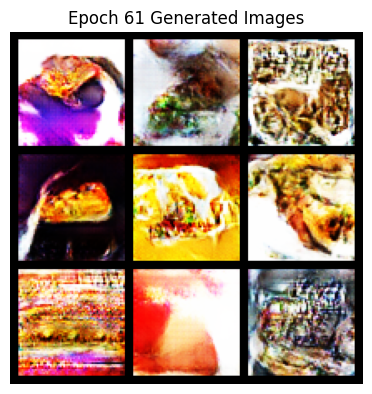

 12%|█▏        | 62/500 [1:03:12<7:14:25, 59.51s/it]

Discriminator Loss EPOCH 62: 2144.7122
Generator Loss EPOCH 62: 5.0904


 13%|█▎        | 63/500 [1:04:11<7:11:49, 59.29s/it]

Discriminator Loss EPOCH 63: 1552.5372
Generator Loss EPOCH 63: 5.0905


 13%|█▎        | 64/500 [1:05:10<7:11:11, 59.34s/it]

Discriminator Loss EPOCH 64: 2125.2844
Generator Loss EPOCH 64: 5.2570


 13%|█▎        | 65/500 [1:06:09<7:09:04, 59.18s/it]

Discriminator Loss EPOCH 65: 1534.9247
Generator Loss EPOCH 65: 5.1079


 13%|█▎        | 66/500 [1:07:08<7:07:30, 59.10s/it]

Discriminator Loss EPOCH 66: 917.1346
Generator Loss EPOCH 66: 5.3338


 13%|█▎        | 67/500 [1:08:07<7:06:04, 59.04s/it]

Discriminator Loss EPOCH 67: 3848.0345
Generator Loss EPOCH 67: 5.5439


 14%|█▎        | 68/500 [1:09:06<7:05:18, 59.07s/it]

Discriminator Loss EPOCH 68: 805.6719
Generator Loss EPOCH 68: 4.9457


 14%|█▍        | 69/500 [1:10:06<7:07:37, 59.53s/it]

Discriminator Loss EPOCH 69: 508.3475
Generator Loss EPOCH 69: 5.1670


 14%|█▍        | 70/500 [1:11:07<7:08:10, 59.75s/it]

Discriminator Loss EPOCH 70: 8298.7852
Generator Loss EPOCH 70: 5.1915


 14%|█▍        | 71/500 [1:12:05<7:04:39, 59.39s/it]

Discriminator Loss EPOCH 71: 1483.2588
Generator Loss EPOCH 71: 4.8503


 14%|█▍        | 72/500 [1:13:04<7:02:41, 59.26s/it]

Discriminator Loss EPOCH 72: 2850.8959
Generator Loss EPOCH 72: 4.9101


 15%|█▍        | 73/500 [1:14:03<7:00:53, 59.14s/it]

Discriminator Loss EPOCH 73: 2028.5079
Generator Loss EPOCH 73: 4.7557


 15%|█▍        | 74/500 [1:15:02<7:00:03, 59.16s/it]

Discriminator Loss EPOCH 74: 2802.2851
Generator Loss EPOCH 74: 5.0580


 15%|█▌        | 75/500 [1:16:01<6:58:04, 59.02s/it]

Discriminator Loss EPOCH 75: 2585.2933
Generator Loss EPOCH 75: 5.0185


 15%|█▌        | 76/500 [1:17:00<6:56:29, 58.94s/it]

Discriminator Loss EPOCH 76: 843.2574
Generator Loss EPOCH 76: 4.8965


 15%|█▌        | 77/500 [1:17:59<6:55:26, 58.93s/it]

Discriminator Loss EPOCH 77: 670.5551
Generator Loss EPOCH 77: 5.0708


 16%|█▌        | 78/500 [1:18:58<6:54:46, 58.97s/it]

Discriminator Loss EPOCH 78: 624.7442
Generator Loss EPOCH 78: 5.1946


 16%|█▌        | 79/500 [1:19:56<6:53:18, 58.90s/it]

Discriminator Loss EPOCH 79: 7401.5588
Generator Loss EPOCH 79: 4.4001


 16%|█▌        | 80/500 [1:20:55<6:52:07, 58.87s/it]

Discriminator Loss EPOCH 80: 2787.5068
Generator Loss EPOCH 80: 5.4177


100%|██████████| 118/118 [00:58<00:00,  2.00it/s]


Discriminator Loss EPOCH 81: 1500.6308
Generator Loss EPOCH 81: 4.7760


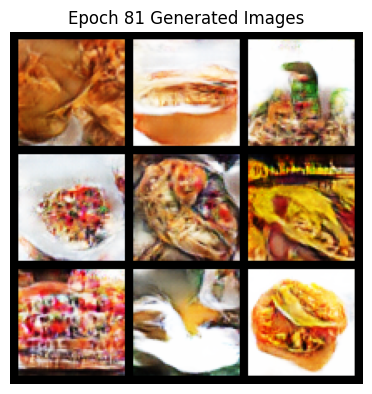

 16%|█▋        | 82/500 [1:22:53<6:50:15, 58.89s/it]

Discriminator Loss EPOCH 82: 751.7581
Generator Loss EPOCH 82: 4.8504


 17%|█▋        | 83/500 [1:23:52<6:49:06, 58.86s/it]

Discriminator Loss EPOCH 83: 472.0911
Generator Loss EPOCH 83: 5.0290


 17%|█▋        | 84/500 [1:24:51<6:48:51, 58.97s/it]

Discriminator Loss EPOCH 84: 3600.4874
Generator Loss EPOCH 84: 4.8543


 17%|█▋        | 85/500 [1:25:51<6:48:49, 59.11s/it]

Discriminator Loss EPOCH 85: 2088.8288
Generator Loss EPOCH 85: 5.0249


 17%|█▋        | 86/500 [1:26:50<6:49:05, 59.29s/it]

Discriminator Loss EPOCH 86: 455.5320
Generator Loss EPOCH 86: 5.1724


 17%|█▋        | 87/500 [1:27:50<6:48:48, 59.39s/it]

Discriminator Loss EPOCH 87: 3078.0437
Generator Loss EPOCH 87: 5.2280


 18%|█▊        | 88/500 [1:28:50<6:49:24, 59.62s/it]

Discriminator Loss EPOCH 88: 2381.3488
Generator Loss EPOCH 88: 5.3004


 18%|█▊        | 89/500 [1:29:50<6:48:21, 59.62s/it]

Discriminator Loss EPOCH 89: 764.8775
Generator Loss EPOCH 89: 5.0069


 18%|█▊        | 90/500 [1:30:49<6:46:39, 59.51s/it]

Discriminator Loss EPOCH 90: 2131.2751
Generator Loss EPOCH 90: 5.3736


 18%|█▊        | 91/500 [1:31:48<6:45:16, 59.45s/it]

Discriminator Loss EPOCH 91: 1709.4098
Generator Loss EPOCH 91: 5.4584


 18%|█▊        | 92/500 [1:32:47<6:43:02, 59.27s/it]

Discriminator Loss EPOCH 92: 646.8688
Generator Loss EPOCH 92: 5.3073


 19%|█▊        | 93/500 [1:33:46<6:41:57, 59.26s/it]

Discriminator Loss EPOCH 93: 2013.2692
Generator Loss EPOCH 93: 5.5701


 19%|█▉        | 94/500 [1:34:46<6:40:55, 59.25s/it]

Discriminator Loss EPOCH 94: 1391.6437
Generator Loss EPOCH 94: 5.6845


 19%|█▉        | 95/500 [1:35:45<6:39:21, 59.16s/it]

Discriminator Loss EPOCH 95: 3837.2778
Generator Loss EPOCH 95: 5.3982


 19%|█▉        | 96/500 [1:36:43<6:37:36, 59.05s/it]

Discriminator Loss EPOCH 96: 1079.7481
Generator Loss EPOCH 96: 5.0427


 19%|█▉        | 97/500 [1:37:43<6:38:15, 59.29s/it]

Discriminator Loss EPOCH 97: 2861.5696
Generator Loss EPOCH 97: 4.7951


 20%|█▉        | 98/500 [1:38:43<6:38:16, 59.44s/it]

Discriminator Loss EPOCH 98: 665.5506
Generator Loss EPOCH 98: 5.1713


 20%|█▉        | 99/500 [1:39:42<6:36:17, 59.29s/it]

Discriminator Loss EPOCH 99: 351.7954
Generator Loss EPOCH 99: 5.3859


100%|██████████| 118/118 [00:58<00:00,  2.01it/s]


Discriminator Loss EPOCH 100: 305.2415
Generator Loss EPOCH 100: 5.5538


 20%|██        | 100/500 [1:40:41<6:35:22, 59.31s/it]

Checkpoint saved at epoch 99


100%|██████████| 118/118 [00:59<00:00,  1.98it/s]


Discriminator Loss EPOCH 101: 4266.1346
Generator Loss EPOCH 101: 5.6995


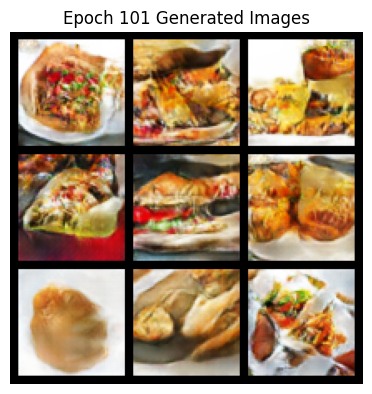

 20%|██        | 102/500 [1:42:40<6:33:32, 59.33s/it]

Discriminator Loss EPOCH 102: 783.6806
Generator Loss EPOCH 102: 5.3123


 21%|██        | 103/500 [1:43:39<6:32:06, 59.26s/it]

Discriminator Loss EPOCH 103: 1029.4201
Generator Loss EPOCH 103: 5.4970


 21%|██        | 104/500 [1:44:39<6:31:19, 59.29s/it]

Discriminator Loss EPOCH 104: 4406.9436
Generator Loss EPOCH 104: 5.5956


 21%|██        | 105/500 [1:45:38<6:30:47, 59.36s/it]

Discriminator Loss EPOCH 105: 612.7336
Generator Loss EPOCH 105: 5.0541


 21%|██        | 106/500 [1:46:37<6:29:58, 59.39s/it]

Discriminator Loss EPOCH 106: 1963.6210
Generator Loss EPOCH 106: 5.2730


 21%|██▏       | 107/500 [1:47:36<6:27:56, 59.23s/it]

Discriminator Loss EPOCH 107: 597.9122
Generator Loss EPOCH 107: 5.3918


 22%|██▏       | 108/500 [1:48:36<6:27:46, 59.35s/it]

Discriminator Loss EPOCH 108: 321.0597
Generator Loss EPOCH 108: 5.5093


 22%|██▏       | 109/500 [1:49:35<6:26:57, 59.38s/it]

Discriminator Loss EPOCH 109: 341.3279
Generator Loss EPOCH 109: 5.7930


 22%|██▏       | 110/500 [1:50:36<6:28:36, 59.79s/it]

Discriminator Loss EPOCH 110: 4588.7044
Generator Loss EPOCH 110: 6.0742


 22%|██▏       | 111/500 [1:51:36<6:27:16, 59.73s/it]

Discriminator Loss EPOCH 111: 2717.9001
Generator Loss EPOCH 111: 5.5498


 22%|██▏       | 112/500 [1:52:35<6:25:14, 59.57s/it]

Discriminator Loss EPOCH 112: 1334.2306
Generator Loss EPOCH 112: 5.1227


 23%|██▎       | 113/500 [1:53:34<6:23:51, 59.51s/it]

Discriminator Loss EPOCH 113: 648.3696
Generator Loss EPOCH 113: 5.2181


 23%|██▎       | 114/500 [1:54:34<6:23:03, 59.54s/it]

Discriminator Loss EPOCH 114: 417.3505
Generator Loss EPOCH 114: 5.4761


 23%|██▎       | 115/500 [1:55:33<6:21:34, 59.47s/it]

Discriminator Loss EPOCH 115: 301.5054
Generator Loss EPOCH 115: 5.6991


 23%|██▎       | 116/500 [1:56:32<6:20:07, 59.39s/it]

Discriminator Loss EPOCH 116: 4888.5715
Generator Loss EPOCH 116: 5.9707


 23%|██▎       | 117/500 [1:57:34<6:23:12, 60.03s/it]

Discriminator Loss EPOCH 117: 849.7349
Generator Loss EPOCH 117: 5.2989


 24%|██▎       | 118/500 [1:58:34<6:22:14, 60.04s/it]

Discriminator Loss EPOCH 118: 1595.6757
Generator Loss EPOCH 118: 5.4453


 24%|██▍       | 119/500 [1:59:34<6:21:45, 60.12s/it]

Discriminator Loss EPOCH 119: 381.7348
Generator Loss EPOCH 119: 5.4943


 24%|██▍       | 120/500 [2:00:35<6:22:02, 60.32s/it]

Discriminator Loss EPOCH 120: 308.9707
Generator Loss EPOCH 120: 5.7040


100%|██████████| 118/118 [01:00<00:00,  1.97it/s]


Discriminator Loss EPOCH 121: 3452.8585
Generator Loss EPOCH 121: 6.3843


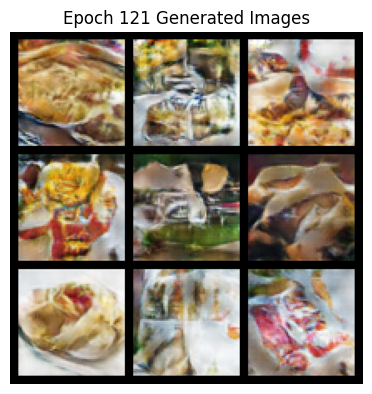

 24%|██▍       | 122/500 [2:02:34<6:16:57, 59.83s/it]

Discriminator Loss EPOCH 122: 1444.7334
Generator Loss EPOCH 122: 5.7306


 25%|██▍       | 123/500 [2:03:33<6:14:23, 59.58s/it]

Discriminator Loss EPOCH 123: 2508.1276
Generator Loss EPOCH 123: 5.7034


 25%|██▍       | 124/500 [2:04:32<6:11:32, 59.29s/it]

Discriminator Loss EPOCH 124: 1541.7124
Generator Loss EPOCH 124: 5.2563


 25%|██▌       | 125/500 [2:05:31<6:09:54, 59.19s/it]

Discriminator Loss EPOCH 125: 535.3947
Generator Loss EPOCH 125: 5.5607


 25%|██▌       | 126/500 [2:06:30<6:08:40, 59.15s/it]

Discriminator Loss EPOCH 126: 333.1688
Generator Loss EPOCH 126: 5.6021


 25%|██▌       | 127/500 [2:07:29<6:07:21, 59.09s/it]

Discriminator Loss EPOCH 127: 344.0632
Generator Loss EPOCH 127: 5.9920


 26%|██▌       | 128/500 [2:08:27<6:05:23, 58.93s/it]

Discriminator Loss EPOCH 128: 4021.0253
Generator Loss EPOCH 128: 5.3596


 26%|██▌       | 129/500 [2:09:26<6:04:21, 58.93s/it]

Discriminator Loss EPOCH 129: 650.2297
Generator Loss EPOCH 129: 5.6448


 26%|██▌       | 130/500 [2:10:25<6:02:55, 58.85s/it]

Discriminator Loss EPOCH 130: 327.9333
Generator Loss EPOCH 130: 5.7535


 26%|██▌       | 131/500 [2:11:23<6:01:15, 58.74s/it]

Discriminator Loss EPOCH 131: 3970.0695
Generator Loss EPOCH 131: 6.3481


 26%|██▋       | 132/500 [2:12:22<6:00:15, 58.74s/it]

Discriminator Loss EPOCH 132: 1512.8770
Generator Loss EPOCH 132: 5.5777


 27%|██▋       | 133/500 [2:13:21<5:59:18, 58.74s/it]

Discriminator Loss EPOCH 133: 481.5970
Generator Loss EPOCH 133: 5.4999


 27%|██▋       | 134/500 [2:14:20<5:58:54, 58.84s/it]

Discriminator Loss EPOCH 134: 398.8766
Generator Loss EPOCH 134: 5.8101


 27%|██▋       | 135/500 [2:15:18<5:57:00, 58.69s/it]

Discriminator Loss EPOCH 135: 3548.7658
Generator Loss EPOCH 135: 5.9246


 27%|██▋       | 136/500 [2:16:17<5:55:50, 58.65s/it]

Discriminator Loss EPOCH 136: 491.0278
Generator Loss EPOCH 136: 5.6312


 27%|██▋       | 137/500 [2:17:16<5:55:01, 58.68s/it]

Discriminator Loss EPOCH 137: 1699.2182
Generator Loss EPOCH 137: 5.5434


 28%|██▊       | 138/500 [2:18:15<5:54:50, 58.81s/it]

Discriminator Loss EPOCH 138: 1188.9325
Generator Loss EPOCH 138: 5.8353


 28%|██▊       | 139/500 [2:19:14<5:55:21, 59.06s/it]

Discriminator Loss EPOCH 139: 456.9370
Generator Loss EPOCH 139: 5.8680


 28%|██▊       | 140/500 [2:20:13<5:54:24, 59.07s/it]

Discriminator Loss EPOCH 140: 302.2006
Generator Loss EPOCH 140: 6.0672


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 141: 387.9600
Generator Loss EPOCH 141: 6.4231


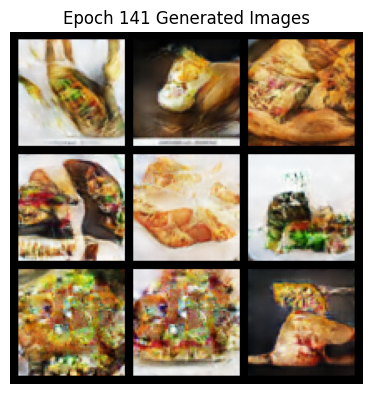

 28%|██▊       | 142/500 [2:22:13<5:54:10, 59.36s/it]

Discriminator Loss EPOCH 142: 3478.6623
Generator Loss EPOCH 142: 6.4273


 29%|██▊       | 143/500 [2:23:12<5:53:00, 59.33s/it]

Discriminator Loss EPOCH 143: 545.3727
Generator Loss EPOCH 143: 5.7331


 29%|██▉       | 144/500 [2:24:12<5:54:20, 59.72s/it]

Discriminator Loss EPOCH 144: 422.1020
Generator Loss EPOCH 144: 6.0420


 29%|██▉       | 145/500 [2:25:13<5:54:59, 60.00s/it]

Discriminator Loss EPOCH 145: 336.6860
Generator Loss EPOCH 145: 6.1745


 29%|██▉       | 146/500 [2:26:13<5:54:38, 60.11s/it]

Discriminator Loss EPOCH 146: 3731.6378
Generator Loss EPOCH 146: 6.7935


 29%|██▉       | 147/500 [2:27:13<5:52:47, 59.96s/it]

Discriminator Loss EPOCH 147: 1532.7751
Generator Loss EPOCH 147: 5.8727


 30%|██▉       | 148/500 [2:28:13<5:51:19, 59.89s/it]

Discriminator Loss EPOCH 148: 1055.9329
Generator Loss EPOCH 148: 5.8429


 30%|██▉       | 149/500 [2:29:12<5:48:50, 59.63s/it]

Discriminator Loss EPOCH 149: 800.0254
Generator Loss EPOCH 149: 5.6654


 30%|███       | 150/500 [2:30:11<5:46:36, 59.42s/it]

Discriminator Loss EPOCH 150: 1783.3945
Generator Loss EPOCH 150: 5.6908


 30%|███       | 151/500 [2:31:13<5:50:22, 60.24s/it]

Discriminator Loss EPOCH 151: 466.4907
Generator Loss EPOCH 151: 5.7646


 30%|███       | 152/500 [2:32:14<5:50:03, 60.36s/it]

Discriminator Loss EPOCH 152: 1984.6481
Generator Loss EPOCH 152: 5.6507


 31%|███       | 153/500 [2:33:12<5:46:19, 59.88s/it]

Discriminator Loss EPOCH 153: 392.5137
Generator Loss EPOCH 153: 5.7160


 31%|███       | 154/500 [2:34:11<5:43:20, 59.54s/it]

Discriminator Loss EPOCH 154: 829.4408
Generator Loss EPOCH 154: 6.3020


 31%|███       | 155/500 [2:35:10<5:41:14, 59.35s/it]

Discriminator Loss EPOCH 155: 435.5124
Generator Loss EPOCH 155: 6.1049


 31%|███       | 156/500 [2:36:10<5:41:51, 59.63s/it]

Discriminator Loss EPOCH 156: 328.9535
Generator Loss EPOCH 156: 6.1165


 31%|███▏      | 157/500 [2:37:11<5:42:25, 59.90s/it]

Discriminator Loss EPOCH 157: 5011.7916
Generator Loss EPOCH 157: 6.8425


 32%|███▏      | 158/500 [2:38:11<5:42:16, 60.05s/it]

Discriminator Loss EPOCH 158: 1700.9324
Generator Loss EPOCH 158: 6.0567


 32%|███▏      | 159/500 [2:39:10<5:39:53, 59.80s/it]

Discriminator Loss EPOCH 159: 1302.6069
Generator Loss EPOCH 159: 5.7158


 32%|███▏      | 160/500 [2:40:10<5:38:28, 59.73s/it]

Discriminator Loss EPOCH 160: 512.0666
Generator Loss EPOCH 160: 6.2467


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 161: 375.1927
Generator Loss EPOCH 161: 6.0370


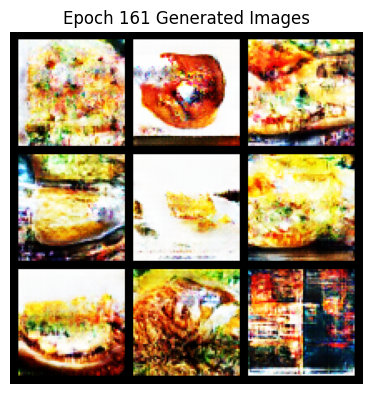

 32%|███▏      | 162/500 [2:42:09<5:35:06, 59.49s/it]

Discriminator Loss EPOCH 162: 340.3811
Generator Loss EPOCH 162: 6.1550


 33%|███▎      | 163/500 [2:43:07<5:32:36, 59.22s/it]

Discriminator Loss EPOCH 163: 8152.6544
Generator Loss EPOCH 163: 6.6467


 33%|███▎      | 164/500 [2:44:06<5:31:33, 59.21s/it]

Discriminator Loss EPOCH 164: 1580.8065
Generator Loss EPOCH 164: 5.6031


 33%|███▎      | 165/500 [2:45:06<5:31:01, 59.29s/it]

Discriminator Loss EPOCH 165: 517.3629
Generator Loss EPOCH 165: 5.6393


 33%|███▎      | 166/500 [2:46:05<5:30:20, 59.34s/it]

Discriminator Loss EPOCH 166: 515.4288
Generator Loss EPOCH 166: 5.9168


 33%|███▎      | 167/500 [2:47:05<5:29:29, 59.37s/it]

Discriminator Loss EPOCH 167: 3112.2842
Generator Loss EPOCH 167: 5.8177


 34%|███▎      | 168/500 [2:48:05<5:30:24, 59.71s/it]

Discriminator Loss EPOCH 168: 462.5868
Generator Loss EPOCH 168: 5.7392


 34%|███▍      | 169/500 [2:49:05<5:29:18, 59.69s/it]

Discriminator Loss EPOCH 169: 1158.8789
Generator Loss EPOCH 169: 5.9206


 34%|███▍      | 170/500 [2:50:04<5:28:02, 59.64s/it]

Discriminator Loss EPOCH 170: 1174.1142
Generator Loss EPOCH 170: 5.8198


 34%|███▍      | 171/500 [2:51:04<5:27:15, 59.68s/it]

Discriminator Loss EPOCH 171: 1218.4940
Generator Loss EPOCH 171: 6.1281


 34%|███▍      | 172/500 [2:52:04<5:26:07, 59.66s/it]

Discriminator Loss EPOCH 172: 337.8932
Generator Loss EPOCH 172: 6.1530


 35%|███▍      | 173/500 [2:53:04<5:26:55, 59.99s/it]

Discriminator Loss EPOCH 173: 1409.6494
Generator Loss EPOCH 173: 6.4144


 35%|███▍      | 174/500 [2:54:04<5:25:46, 59.96s/it]

Discriminator Loss EPOCH 174: 358.5795
Generator Loss EPOCH 174: 6.0208


 35%|███▌      | 175/500 [2:55:04<5:24:33, 59.92s/it]

Discriminator Loss EPOCH 175: 350.3471
Generator Loss EPOCH 175: 6.5350


 35%|███▌      | 176/500 [2:56:04<5:23:57, 59.99s/it]

Discriminator Loss EPOCH 176: 5375.7134
Generator Loss EPOCH 176: 6.3777


 35%|███▌      | 177/500 [2:57:04<5:22:30, 59.91s/it]

Discriminator Loss EPOCH 177: 484.6800
Generator Loss EPOCH 177: 5.8071


 36%|███▌      | 178/500 [2:58:04<5:20:57, 59.81s/it]

Discriminator Loss EPOCH 178: 374.8776
Generator Loss EPOCH 178: 5.9099


 36%|███▌      | 179/500 [2:59:03<5:19:33, 59.73s/it]

Discriminator Loss EPOCH 179: 409.4201
Generator Loss EPOCH 179: 6.3131


 36%|███▌      | 180/500 [3:00:02<5:17:35, 59.55s/it]

Discriminator Loss EPOCH 180: 286.4087
Generator Loss EPOCH 180: 6.2349


100%|██████████| 118/118 [00:59<00:00,  2.00it/s]


Discriminator Loss EPOCH 181: 2713.9699
Generator Loss EPOCH 181: 6.4654


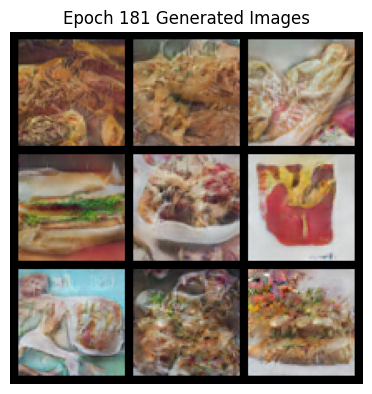

 36%|███▋      | 182/500 [3:02:01<5:14:26, 59.33s/it]

Discriminator Loss EPOCH 182: 612.6077
Generator Loss EPOCH 182: 6.0895


 37%|███▋      | 183/500 [3:03:00<5:13:42, 59.38s/it]

Discriminator Loss EPOCH 183: 374.0655
Generator Loss EPOCH 183: 6.3775


 37%|███▋      | 184/500 [3:04:00<5:12:49, 59.40s/it]

Discriminator Loss EPOCH 184: 2873.8440
Generator Loss EPOCH 184: 7.1604


 37%|███▋      | 185/500 [3:04:59<5:11:48, 59.39s/it]

Discriminator Loss EPOCH 185: 1011.6236
Generator Loss EPOCH 185: 6.0860


 37%|███▋      | 186/500 [3:05:58<5:10:16, 59.29s/it]

Discriminator Loss EPOCH 186: 1355.8000
Generator Loss EPOCH 186: 6.4057


 37%|███▋      | 187/500 [3:06:57<5:08:26, 59.13s/it]

Discriminator Loss EPOCH 187: 668.6081
Generator Loss EPOCH 187: 5.9283


 38%|███▊      | 188/500 [3:07:56<5:07:59, 59.23s/it]

Discriminator Loss EPOCH 188: 356.0229
Generator Loss EPOCH 188: 6.1737


 38%|███▊      | 189/500 [3:08:56<5:08:11, 59.46s/it]

Discriminator Loss EPOCH 189: 349.3066
Generator Loss EPOCH 189: 6.5883


 38%|███▊      | 190/500 [3:09:56<5:08:05, 59.63s/it]

Discriminator Loss EPOCH 190: 1761.3438
Generator Loss EPOCH 190: 6.6120


 38%|███▊      | 191/500 [3:10:56<5:07:07, 59.64s/it]

Discriminator Loss EPOCH 191: 435.8803
Generator Loss EPOCH 191: 6.9892


 38%|███▊      | 192/500 [3:11:55<5:05:53, 59.59s/it]

Discriminator Loss EPOCH 192: 294.0168
Generator Loss EPOCH 192: 6.6308


 39%|███▊      | 193/500 [3:12:59<5:11:55, 60.96s/it]

Discriminator Loss EPOCH 193: 1142.9451
Generator Loss EPOCH 193: 6.9280


 39%|███▉      | 194/500 [3:14:01<5:11:50, 61.15s/it]

Discriminator Loss EPOCH 194: 541.3325
Generator Loss EPOCH 194: 7.1003


 39%|███▉      | 195/500 [3:15:06<5:17:02, 62.37s/it]

Discriminator Loss EPOCH 195: 262.9425
Generator Loss EPOCH 195: 6.6859


 39%|███▉      | 196/500 [3:16:09<5:16:46, 62.52s/it]

Discriminator Loss EPOCH 196: 260.8565
Generator Loss EPOCH 196: 6.7388


 39%|███▉      | 197/500 [3:17:10<5:13:08, 62.01s/it]

Discriminator Loss EPOCH 197: 282.7616
Generator Loss EPOCH 197: 7.3036


 40%|███▉      | 198/500 [3:18:09<5:07:24, 61.07s/it]

Discriminator Loss EPOCH 198: 223.1757
Generator Loss EPOCH 198: 6.7542


 40%|███▉      | 199/500 [3:19:08<5:03:50, 60.57s/it]

Discriminator Loss EPOCH 199: 7215.6287
Generator Loss EPOCH 199: 7.1059


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 200: 566.3932
Generator Loss EPOCH 200: 6.1341


 40%|████      | 200/500 [3:20:08<5:01:20, 60.27s/it]

Checkpoint saved at epoch 199


100%|██████████| 118/118 [00:59<00:00,  1.99it/s]


Discriminator Loss EPOCH 201: 393.3675
Generator Loss EPOCH 201: 6.6080


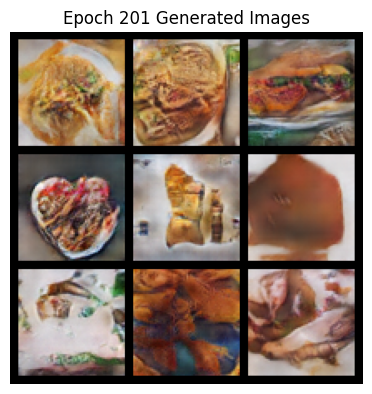

 40%|████      | 202/500 [3:22:06<4:56:39, 59.73s/it]

Discriminator Loss EPOCH 202: 276.2965
Generator Loss EPOCH 202: 6.3584


 41%|████      | 203/500 [3:23:06<4:55:15, 59.65s/it]

Discriminator Loss EPOCH 203: 6143.9550
Generator Loss EPOCH 203: 7.0572


 41%|████      | 204/500 [3:24:05<4:54:03, 59.61s/it]

Discriminator Loss EPOCH 204: 1478.6553
Generator Loss EPOCH 204: 6.0824


 41%|████      | 205/500 [3:25:05<4:53:57, 59.79s/it]

Discriminator Loss EPOCH 205: 438.1262
Generator Loss EPOCH 205: 5.8173


 41%|████      | 206/500 [3:26:06<4:53:22, 59.87s/it]

Discriminator Loss EPOCH 206: 516.6134
Generator Loss EPOCH 206: 6.3637


 41%|████▏     | 207/500 [3:27:05<4:51:44, 59.74s/it]

Discriminator Loss EPOCH 207: 299.6119
Generator Loss EPOCH 207: 6.1409


 42%|████▏     | 208/500 [3:28:05<4:51:12, 59.84s/it]

Discriminator Loss EPOCH 208: 303.8287
Generator Loss EPOCH 208: 6.3270


 42%|████▏     | 209/500 [3:29:06<4:51:56, 60.19s/it]

Discriminator Loss EPOCH 209: 305.0970
Generator Loss EPOCH 209: 7.5838


 42%|████▏     | 210/500 [3:30:07<4:52:26, 60.50s/it]

Discriminator Loss EPOCH 210: 1669.1985
Generator Loss EPOCH 210: 7.4025


 42%|████▏     | 211/500 [3:31:08<4:51:43, 60.56s/it]

Discriminator Loss EPOCH 211: 602.8568
Generator Loss EPOCH 211: 6.5796


 42%|████▏     | 212/500 [3:32:07<4:48:30, 60.11s/it]

Discriminator Loss EPOCH 212: 349.8715
Generator Loss EPOCH 212: 6.5599


 43%|████▎     | 213/500 [3:33:06<4:46:11, 59.83s/it]

Discriminator Loss EPOCH 213: 2486.6963
Generator Loss EPOCH 213: 7.1787


 43%|████▎     | 214/500 [3:34:05<4:43:59, 59.58s/it]

Discriminator Loss EPOCH 214: 430.0522
Generator Loss EPOCH 214: 6.4023


 43%|████▎     | 215/500 [3:35:04<4:42:06, 59.39s/it]

Discriminator Loss EPOCH 215: 290.9989
Generator Loss EPOCH 215: 6.4175


 22%|██▏       | 26/118 [00:12<00:42,  2.14it/s]

In [ ]:
criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

generator.train()
discriminator.train()

generator_params = sum(p.numel() for p in generator.parameters())
discriminator_params = sum(p.numel() for p in discriminator.parameters())

print(f"Generator params: {generator_params}")
print(f"Discriminator params: {discriminator_params}")

def save_checkpoint(epoch, generator, discriminator, gen_opt, disc_opt, checkpoint_dir=CHECKPOINT):
    checkpoint = {
        "epoch": epoch,
        "generator_state_dict":  generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "generator_optimizer_state_dict": gen_opt.state_dict(),
        "discriminator_optimizer_state_dict": disc_opt.state_dict(),
    }
    torch.save(checkpoint, f"{CHECKPOINT}/checkpoint_epoch_{epoch}.pth")
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(checkpoint_path, generator, discriminator, gen_opt, disc_opt):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    gen_opt.load_state_dict(checkpoint["gen_opt_state_dict"])
    disc_opt.load_state_dict(checkpoint["disc_opt_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    return start_epoch

start_epoch = 0

resume_training = False
checkpoint_path = f"{CHECKPOINT}/checkpoint_epoch_100.pth"

if resume_training:
    start_epoch = load_checkpoint(checkpoint_path, generator, discriminator, generator_optimizer, discriminator_optimizer)

start = timeit.default_timer()
for epoch in tqdm(range(start_epoch, EPOCHS), position=0, leave=True):
  generator_running_lost = 0
  discriminator_running_lost = 0
  for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
    img_data = data[0].to(device)
    dummy_labels = data[1]

    real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device)
    fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)

    discriminator_real_out = discriminator(img_data).view(-1)
    discriminator_real_loss = criterion(discriminator_real_out, real_labels)
    discriminator.zero_grad()
    discriminator_real_loss.backward()

    noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
    generator_fake_out = generator(noise)
    discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1)
    discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
    discriminator_fake_loss.backward()
    discriminator_running_lost += discriminator_real_loss.item() + discriminator_fake_loss.item()
    discriminator_optimizer.step()

    discriminator_fake_out = discriminator(generator_fake_out).view(-1)
    generator_loss = criterion(discriminator_fake_out, real_labels)
    generator_running_lost += generator_loss.item()
    generator.zero_grad()
    generator_loss.backward()
    generator_optimizer.step()

  discriminator_loss = discriminator_running_lost / 2 *(idx+1)
  generator_loss = generator_running_lost / (idx+1)

  print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
  print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")

  if epoch % 20 == 0:  
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(), (1,2,0)))
    plt.show()

  if (epoch + 1) % 100 == 0:
    save_checkpoint(epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)

stop = timeit.default_timer()
print(f"Training time: {stop-start:.2f}s")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
generator_fake_out = generator(noise)
plt.imshow(generator_fake_out[2].detach().cpu().permute(1, 2, 0))

In [ ]:
https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset?scriptVersionId=6886724&cellId=23